# Plotting Tools
Some basic plotting tools used throughout the notebook.

In [1]:
# Plot 2 images side-by-side
def plot_sbs(img1, img2, cmap1 = 'brg', cmap2 = 'brg'):
    
    plt.figure(figsize = (16, 20))
    plt.subplot(1,2,1)
    plt.imshow(img1, cmap1)
    plt.subplot(1,2,2)
    plt.imshow(img2, cmap2)
    

# Extract Sample Images from Challenge Video
Here, I'll grab some images for use throughout this notebook.

In [2]:
import cv2
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


from moviepy.editor import VideoFileClip

# Times for frames to extract
times = np.arange(0,50,5)

clear1 = None
clip1 = VideoFileClip("project_video.mp4")

raw_imgs = []

for time in times:
    raw_imgs.append(clip1.get_frame(time))
    

# Camera Calibration

In [3]:

import glob

# Read in images
cal_files = glob.glob('camera_cal/*.jpg')

cal_imgs = []
for file in cal_files:
    cal_imgs.append(mpimg.imread(file)) #RGB image
    
"""
for img in cal_imgs:
    plt.figure()
    plt.imshow(img)
"""

'\nfor img in cal_imgs:\n    plt.figure()\n    plt.imshow(img)\n'

In [4]:

def cal_camera(imgs, nc = (9,6), plots = False):
    
    objpoints = []
    imgpoints = []
    
    objp = np.zeros((nc[0]*nc[1], 3), np.float32)
    objp[:,:2] = np.mgrid[0:nc[0], 0:nc[1]].T.reshape(-1,2)
    
    shape = imgs[0].shape[1::-1]
    
    for img in imgs:
        # Convert to grayscale
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, nc, None)

        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)

            #img = cv2.drawChessboardCorners(img, nc, corners, ret)
            #plt.figure()
            #plt.imshow(img)
    
    retval, matrix, distortion, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, shape, None, None)
    
    return matrix, distortion



save_mtx = 'camera_cal/cam_cal_mtx.p'
save_dist = 'camera_cal/cam_cal_dist.p'

action = 'load'

if(action == 'gen'):
    mtx, dist = cal_camera(cal_imgs)
    pickle.dump(mtx, open(save_mtx, "wb" ))
    pickle.dump(dist, open(save_dist, "wb" ))
elif(action == 'load'):
    with open(save_mtx, mode='rb') as f:
        mtx = pickle.load(f)
    with open(save_dist, mode='rb') as f:
        dist = pickle.load(f)
else:
    print("Choose whether to generate or load camera calibration data.")
    

# Undistort Images


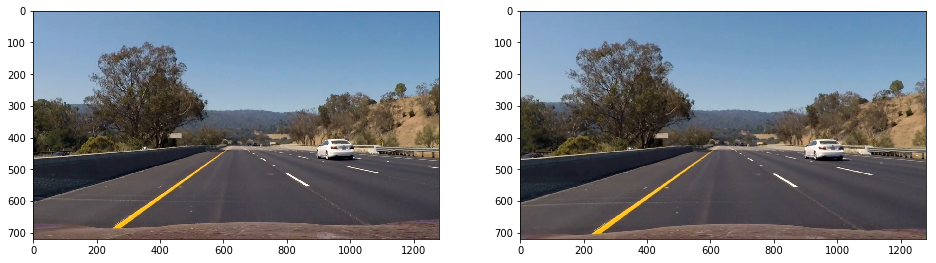

In [5]:
# Undistort an image

def undistort(img, mtx, dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

undist_imgs = []

for img in raw_imgs:
    undist_imgs.append(undistort(img, mtx, dist))

plot_sbs(raw_imgs[4], undist_imgs[4])

# Thresholding

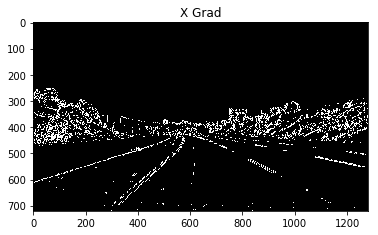

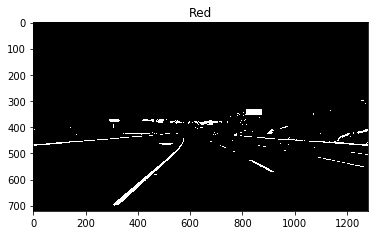

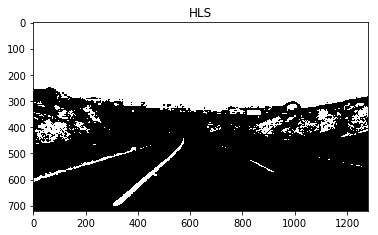

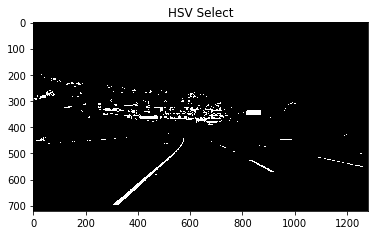

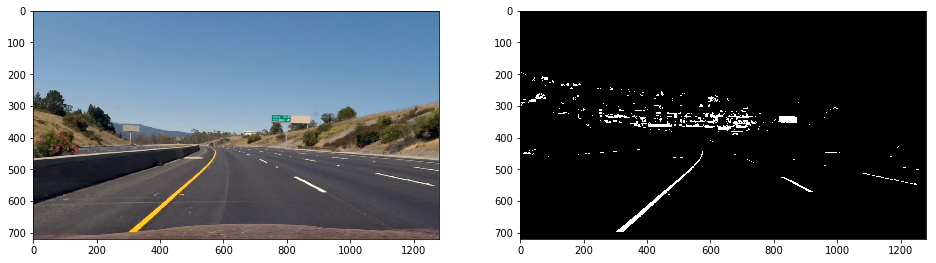

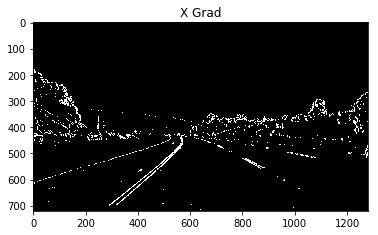

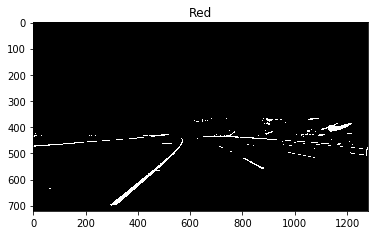

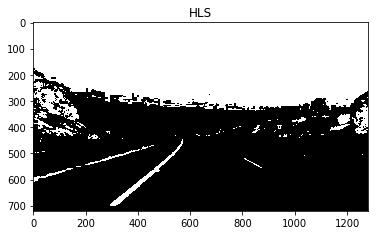

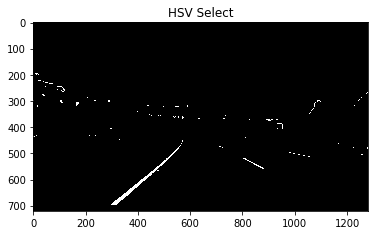

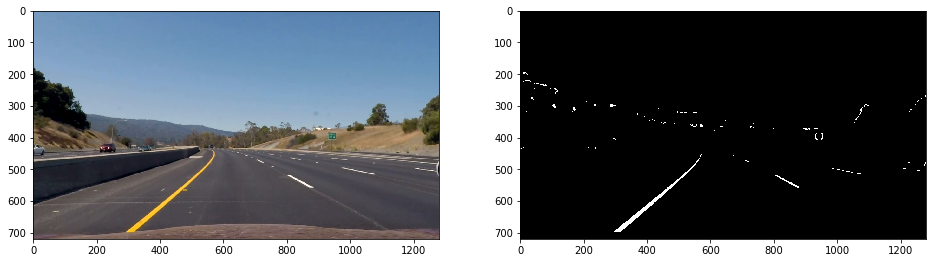

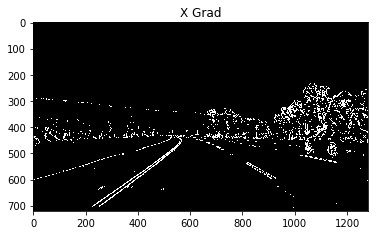

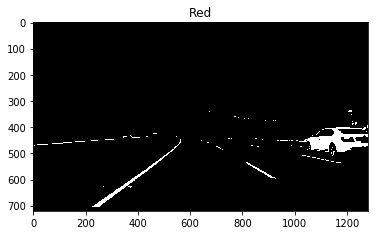

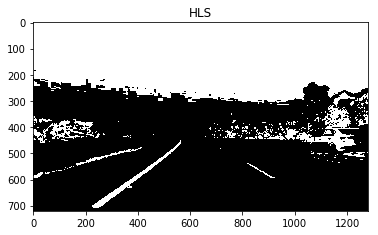

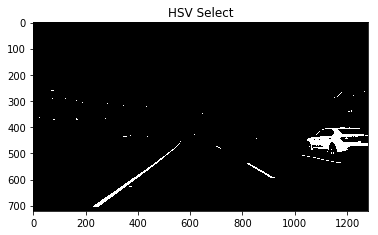

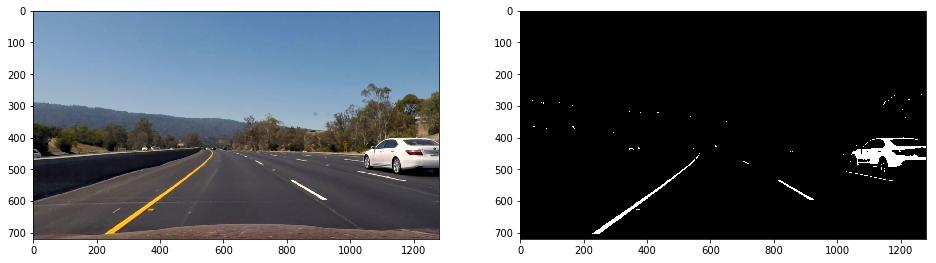

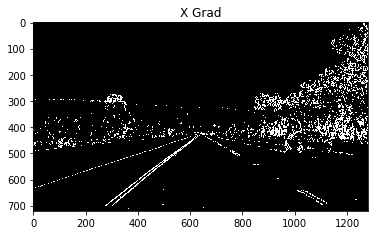

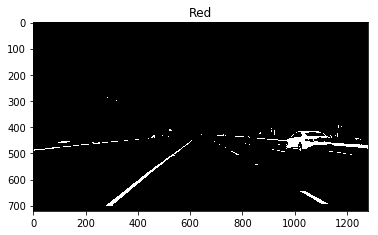

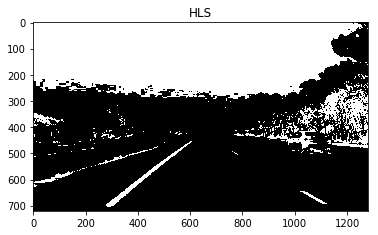

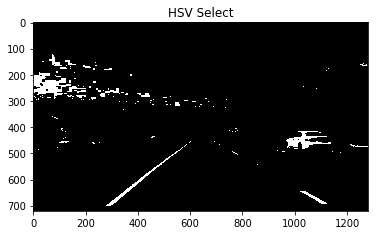

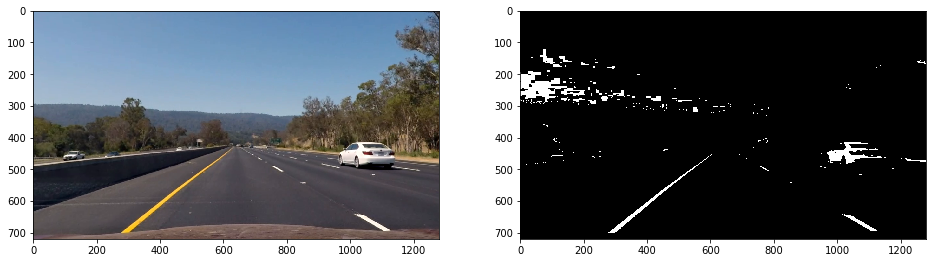

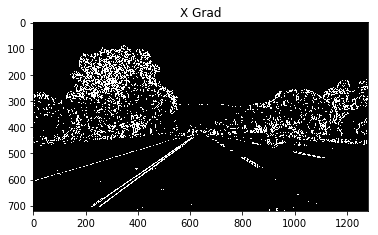

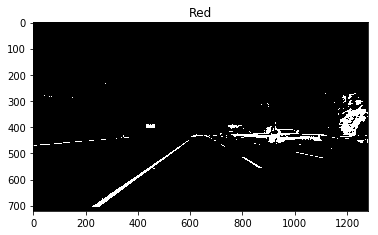

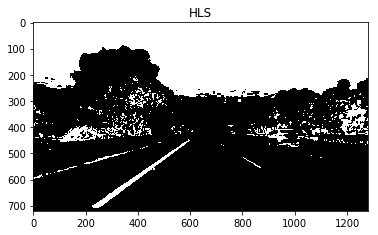

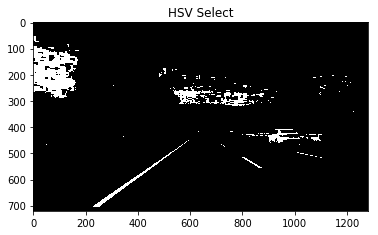

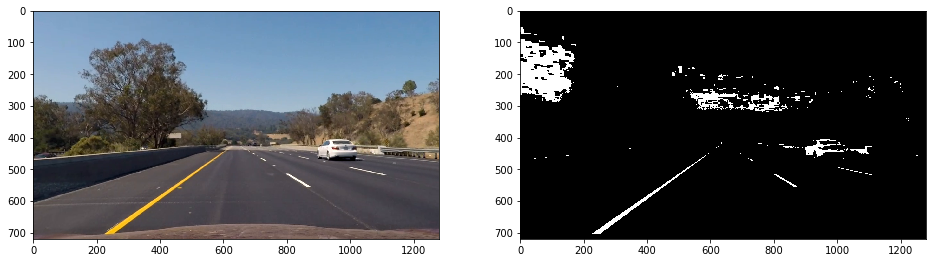

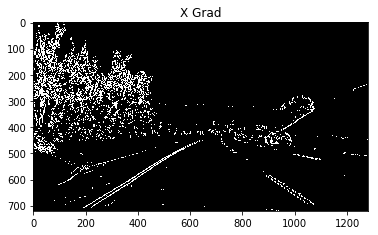

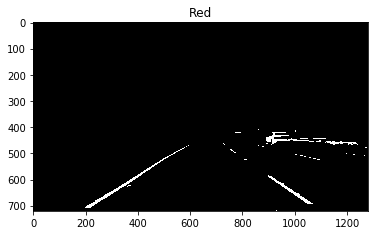

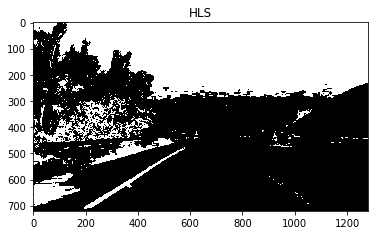

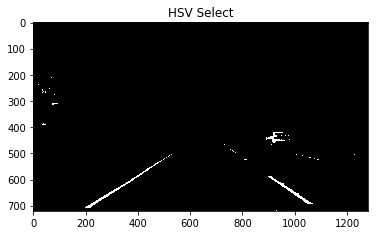

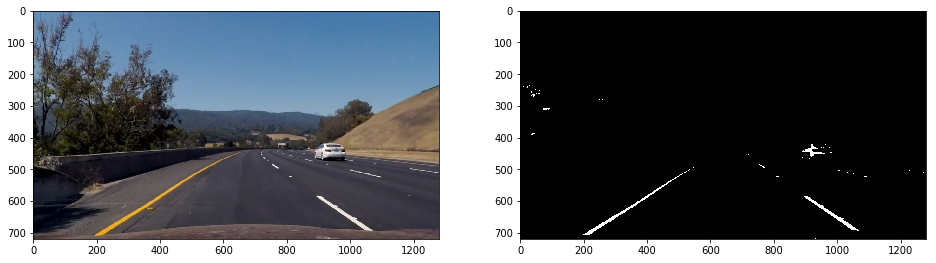

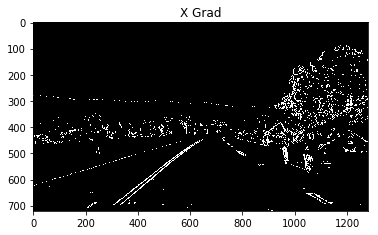

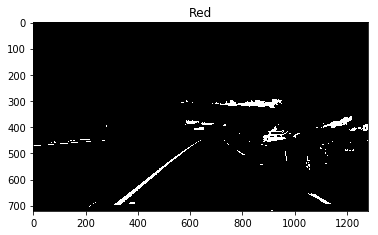

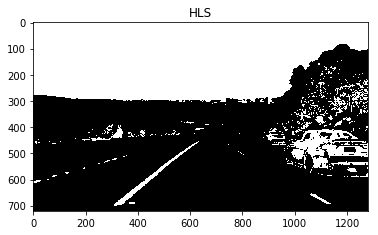

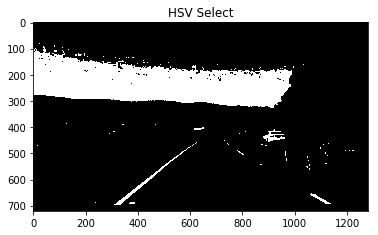

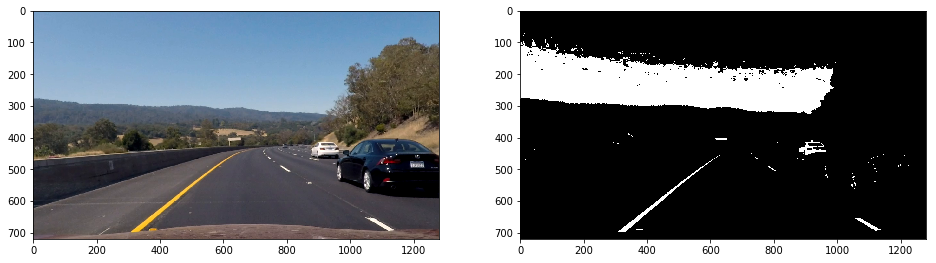

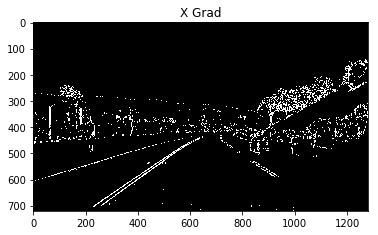

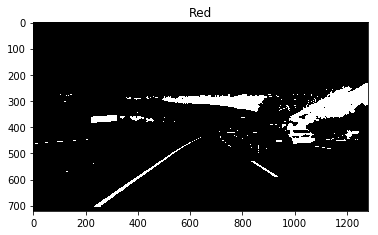

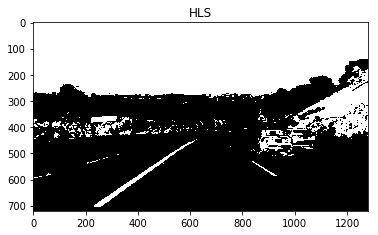

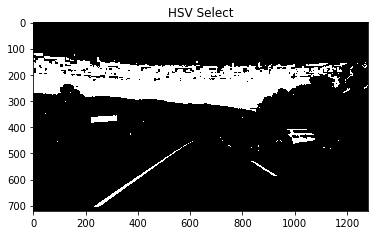

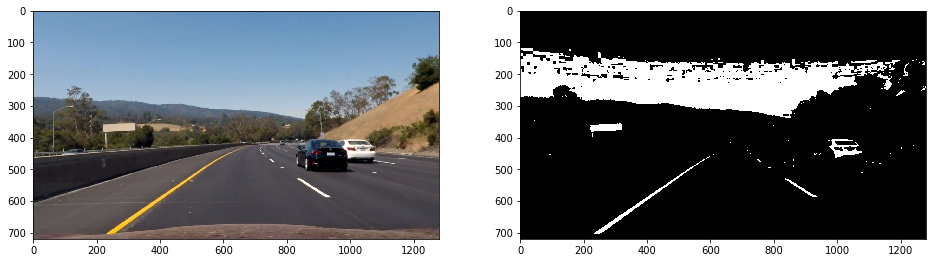

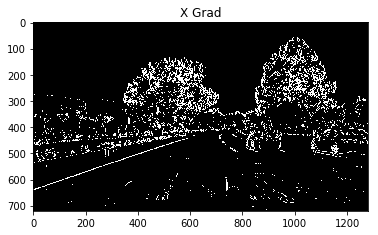

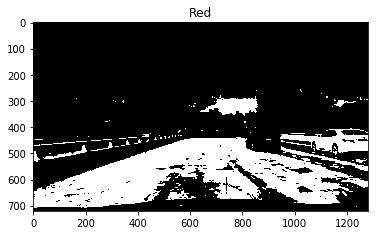

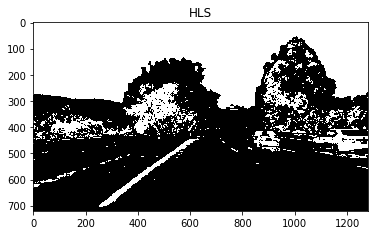

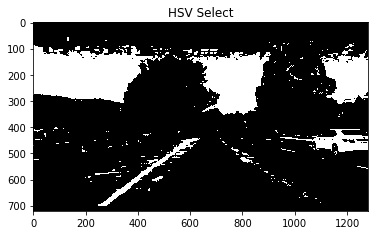

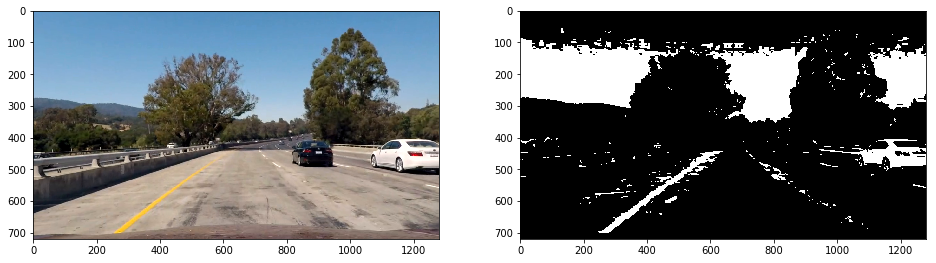

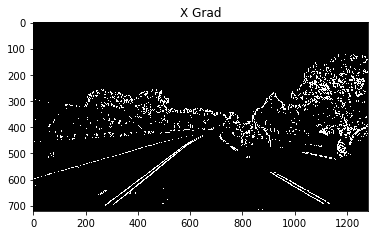

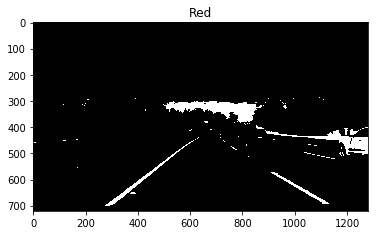

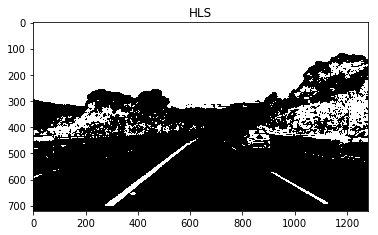

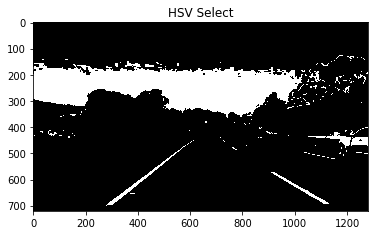

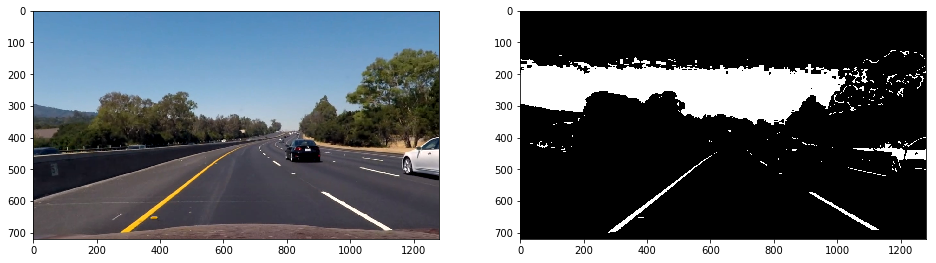

In [15]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh = (0, 255)):
    
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
   
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    return binary_output


def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

def hsv_select(img, color1_lower, color1_upper, color2_lower, color2_upper):
    """ Applies an HSV color transform, and performs color selection of two colors
    Color selection was performed in the HSV color space, since it's much easier to pick
    out individual colors than in RGB space
    """
    #Convert to hsv
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    # Generate masks
    mask2 = cv2.inRange(hsv, color2_lower, color2_upper)
    mask1 = cv2.inRange(hsv, color1_lower, color1_upper)
    
    
    # Apply mask to original image
    mask = cv2.bitwise_or(mask1, mask2)
    
    binary_output = np.zeros_like(mask).astype(np.uint8)
    binary_output[mask>0] = 1; # convert to 0-1
    
    return binary_output


def red_select(img, thresh=(0,255)):
    red = img[:,:,0]
    binary_output = np.zeros_like(red)
    binary_output[(red > thresh[0]) & (red <= thresh[1])] = 1
    return binary_output


def thresh_fcn(img, ksize=5, xythresh=(20,100), magthresh=(10,100), 
               dirthresh=(0.6, 1.0), redthresh=(170,255), hlsthresh=(80,255), plot = False):
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=xythresh)
    if plot:
        plt.figure()
        plt.imshow(gradx, cmap='gray')
        plt.title('X Grad')
    
    """
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=xythresh)
    plt.figure()
    plt.imshow(grady, cmap='gray')
    plt.title('Y Grad')
    """
    # Define yellow and white colors for used in color selection
    lower_yellow = np.array([40, 40, 40])
    upper_yellow = np.array([70, 255, 255])
    lower_white = np.array([0, 0, 205])
    upper_white = np.array([255, 255, 255])
    
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=magthresh)
    if False:
        plt.figure()
        plt.imshow(mag_binary, cmap='gray')
        plt.title('Grad Magnitude')
    
    dir_binary = dir_threshold(gray, sobel_kernel=15, thresh=dirthresh)
    if False:
        plt.figure()
        plt.imshow(dir_binary, cmap='gray')
        plt.title('Grad Dir')
    
    red_binary = red_select(img, thresh=redthresh)
    if plot:
        plt.figure()
        plt.imshow(red_binary, cmap='gray')
        plt.title('Red')
    
    hls_binary = hls_select(img, thresh=hlsthresh)
    if plot:
        plt.figure()
        plt.imshow(hls_binary, cmap='gray')
        plt.title('HLS')
        
        
    hsv_binary = hsv_select(img, lower_yellow, upper_yellow, lower_white, upper_white)
    if plot:
        plt.figure()
        plt.imshow(hsv_binary, cmap='gray')
        plt.title('HSV Select')

    newimg = np.zeros_like(img[:,:,0])
    #newimg[(((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))) & (red_binary == 1) & (hls_binary == 1)] = 1
    
    #removed the y grad
    #newimg[((gradx == 1) | ((mag_binary == 1) & (dir_binary == 1))) & (red_binary == 1) & (hls_binary == 1)] = 1
    
    #Using only HLS and red
    #newimg[ (red_binary == 1) & (hls_binary == 1)] = 1
    
    #newimg[(hsv_binary == 1) & (red_binary == 1)] = 1

    
    newimg[(hsv_binary == 1)] = 1
    
    
    return newimg

"""
test_img = cv2.cvtColor(raw_imgs[14], cv2.COLOR_RGB2HLS)
s_channel = test_img[:,:,2]
plt.imshow(s_channel, cmap='gray')
"""

thresh_imgs = []
for i in range(len(undist_imgs)): #undist_imgs
    thresh_imgs.append(thresh_fcn(undist_imgs[i], plot=True))
    plot_sbs(undist_imgs[i], thresh_imgs[i], cmap2 = 'gray')
    
    

# Perspective Transform

In theory, any image (of the size that we're using, at least) that has been corrected for distortion could be used to determine how to warp the perspective to plot lane lines. Therefore, I'll do this with one of the provided "straight" line images, since frames with straight lines are scarce in the challenge video.

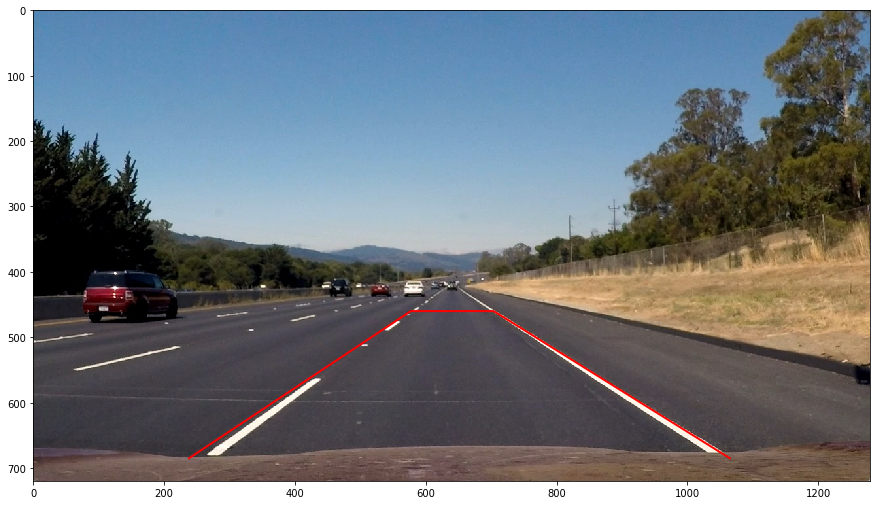

In [16]:
# Grab an image to use for calibrating the perspective warp
strt_img = mpimg.imread('test_images/straight_lines2.jpg')
shp = strt_img.shape

# Pick out some points - these were fine-tuned by hand
xpnts = [238, 577, 704, 1065]
ypnts = [shp[0]-35, 460, 460, shp[0]-35,]

# Plot points
plt.figure(figsize = (15,25));
plt.imshow(strt_img);
plt.plot(xpnts, ypnts, 'r-', linewidth=2);


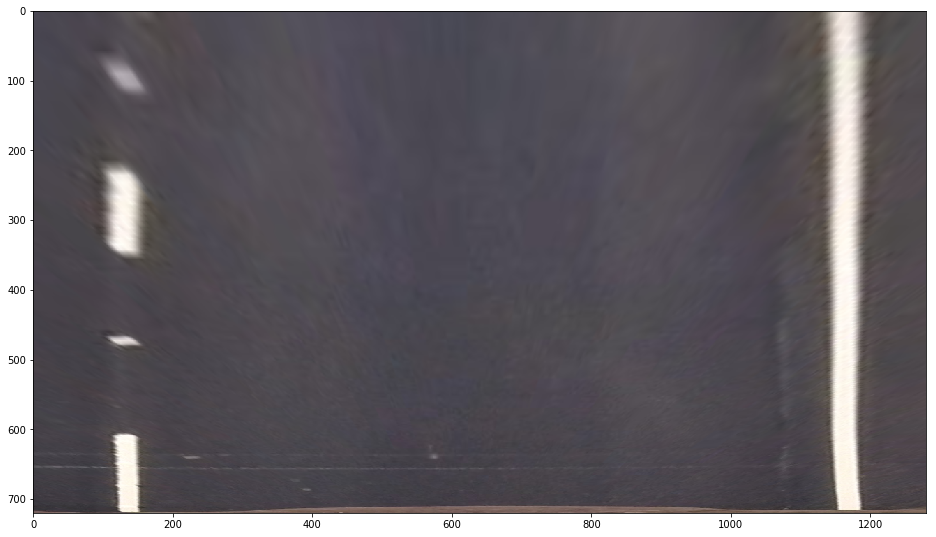

In [17]:
# Define a warping function to do the perspective transform
def warpPers(img):
    
    #Hard-coding the values here
    xpnts = [238, 577, 707, 1066]
    ypnts = [720-35, 460, 460, 720-35,]
    
    # Reshape to the format required by cv2
    srcx = np.array(xpnts)[np.newaxis].T
    srcy = np.array(ypnts)[np.newaxis].T
    src = np.concatenate((srcx, srcy), axis=1).astype(np.float32)
    
    ofst = 100
    dst = np.float32([[ofst, shp[0]], [ofst, 0], [shp[1]-ofst, 0], [shp[1]-ofst, shp[0]]])

    # Warp
    M = cv2.getPerspectiveTransform(src,dst)
    warped = cv2.warpPerspective(img, M, (shp[1], shp[0]))
    
    return warped

plt.figure(figsize=(16, 24));
plt.imshow(warpPers(strt_img));

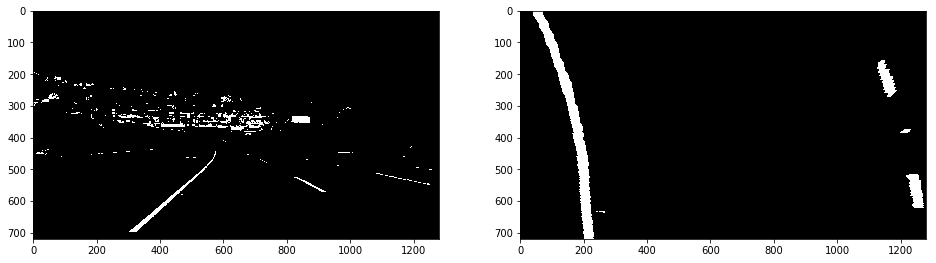

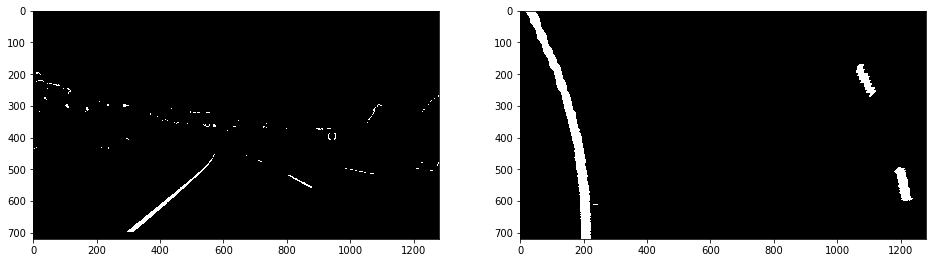

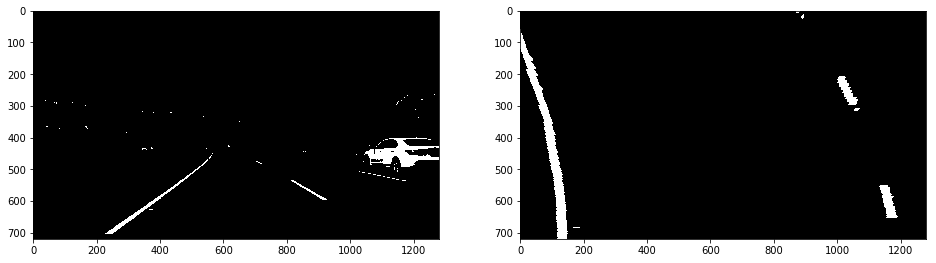

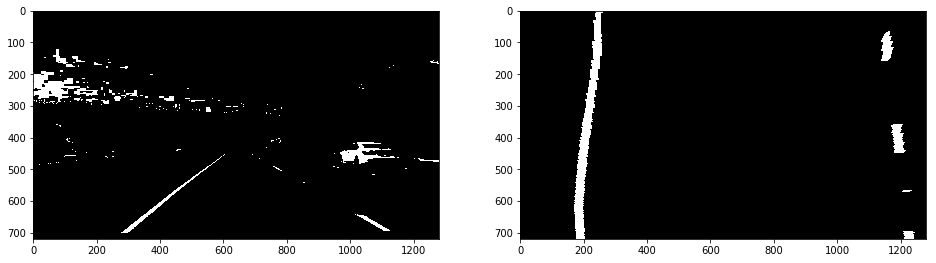

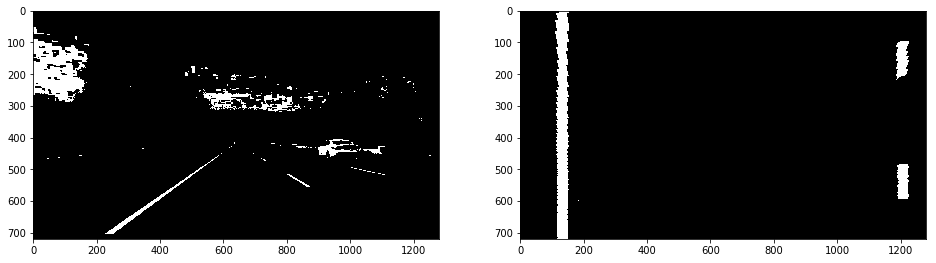

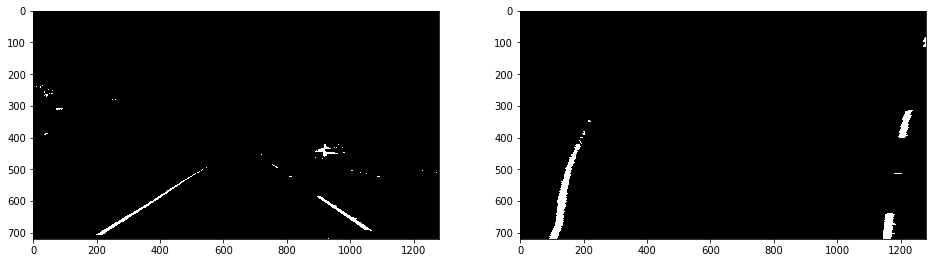

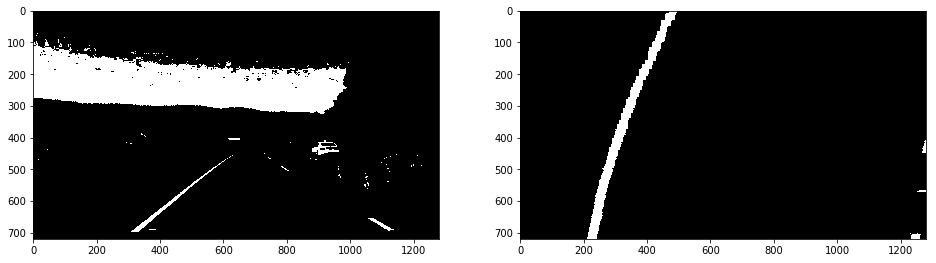

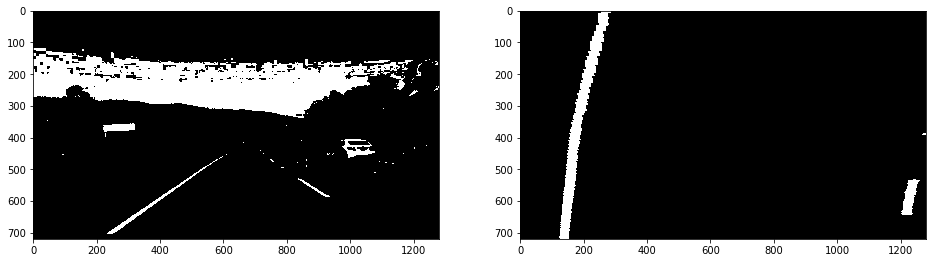

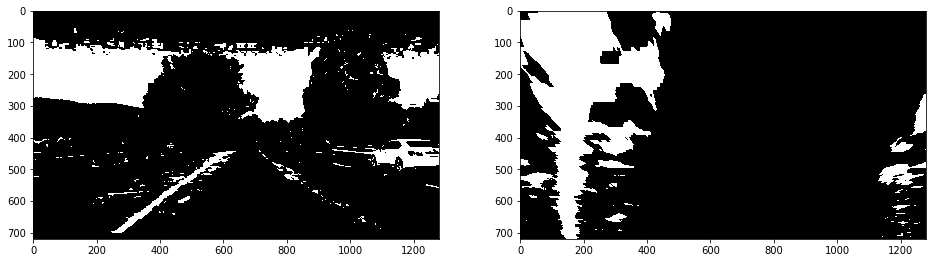

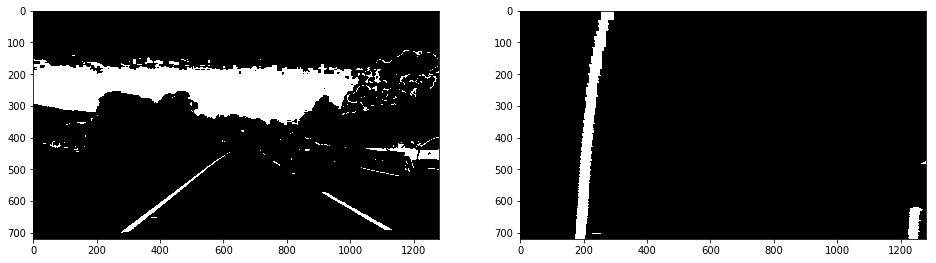

In [18]:
# Try on a few images from the video

warp_imgs = []
for img in thresh_imgs:
    warp_imgs.append(warpPers(img))
    plot_sbs(img, warp_imgs[-1], cmap1='gray', cmap2='gray')
    


# 